## Steps
### Step 1: Import and install required libraries
### Step 2: Load data
- Training data without pertubation
- Training data with pertubation
- Validation data

### Step 3: Visualize Datasets
- Are the datasets balanced?

### Step 4: Data Preprocessing
- Normalize/Transform the data
- Dividing an image by 255 rescales the image from 255 to 0-1
- Reshaping x_train and x_val

### Step 5: Data Augmentation
https://keras.io/api/preprocessing/image/
- Generate batches of tensor image data with real-time data augmentation.

### Step 6: Setting the Model
- Convolution Layer and Max Pool 1 
- Convolution Layer and Max Pool 2
- Dropout Layer
    - https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
- Flatten to a 1D Tensor
- Dense Output Layer with 2 nodes with softmax activation
    - Returns probability of an image belonging to a class 

### Step 7: Model Evaluation and Predictions
- Accuracy and Loss
- Confusion Matrix
- Classification Report by sklearn

<hr>

In [1]:
# %pip install opencv-python
# %pip install matplotlib

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import cv2
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
import seaborn as sns
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

In [3]:
epochs = 8
batch_size = 16
img_size = 224

In [4]:
labels = ['female', 'male']

def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [5]:
train = get_data('preprocessing/train_data')
val = get_data('preprocessing/val_data')
train_pert = get_data('preprocessing/makeup')

'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


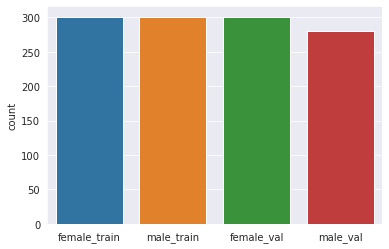

In [6]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("female_train")
    else:
        l.append("male_train")
for j in val:
    if(j[1] == 0):
        l.append("female_val")
    else:
        l.append("male_val")
sns.set_style('darkgrid')
g = sns.countplot(l)

# Without Pertubations

In [7]:
# Data Preprocessing / Feature Engineering
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [8]:
# Augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [9]:
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32, 3, 3, padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

# Convolutional layer 2
model.add(Conv2D(64, 3, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(2, activation="softmax"))

model.summary()
#-----------------------------------------------------------------
opt = Adam(lr=0.000001)
model.compile(optimizer = opt , 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])
#------------------------------------------------------------------
# early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)
checkpoint = ModelCheckpoint('model_best_weights.h5', monitor='loss', verbose=1, # Saves checkpoints
                             save_best_only=True, mode='min', save_freq='epoch')


history = model.fit(x_train,y_train,epochs = epochs , 
                    validation_data = (x_val, y_val), 
                    callbacks = [checkpoint])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4

# With Pertubations

In [10]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train_pert:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [11]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [12]:
model_pert = Sequential()

model_pert.add(Conv2D(32, 3, 3, padding="same", activation="relu", input_shape=(224,224,3)))
model_pert.add(MaxPool2D())

model_pert.add(Conv2D(64, 3, 3, padding="same", activation="relu"))
model_pert.add(MaxPool2D())
model_pert.add(Dropout(0.4))

model_pert.add(Flatten())
model_pert.add(Dense(2, activation="softmax"))

model_pert.summary()
#-----------------------------------------------------------------
opt = Adam(lr=0.000001)
model_pert.compile(optimizer = opt , 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])
#------------------------------------------------------------------
# early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)
checkpoint = ModelCheckpoint('model_best_weights_pert.h5', monitor='loss', verbose=1, # Saves checkpoints
                             save_best_only=True, mode='min', save_freq='epoch')

history_pert = model_pert.fit(x_train,y_train,epochs = epochs , 
                    validation_data = (x_val, y_val), 
                    callbacks = [checkpoint])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 75, 75, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

# Model Evaluation

## Without Pertubation

### Accuracy and Loss

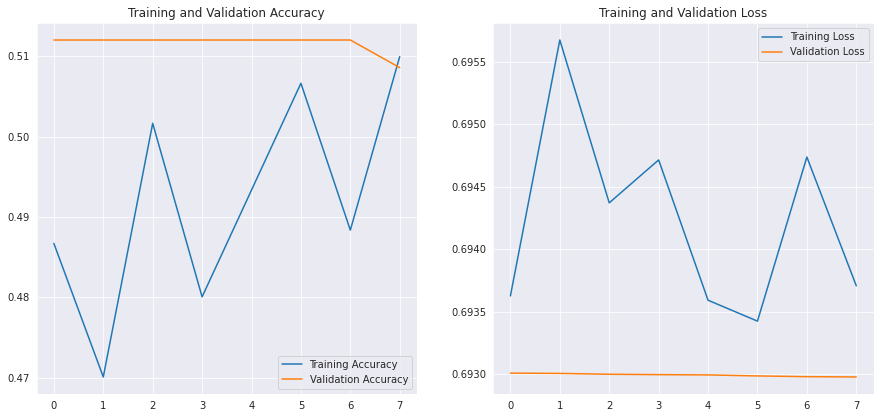

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Confusion Matrix

In [14]:
num_of_train_samples = 602
num_of_test_samples = 582

In [15]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
validation_generator = test_datagen.flow_from_directory("preprocessing/val_data",
                                                        target_size=(224, 224),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 587 images belonging to 2 classes.


Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[290  15]
 [265  17]]


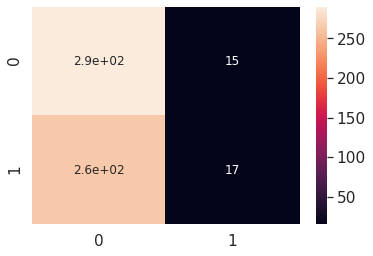

In [17]:
Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
confusion_matrix_array = confusion_matrix(validation_generator.classes, y_pred)
print(confusion_matrix_array)
df_cm = pd.DataFrame(confusion_matrix_array, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

### Classification Report

In [18]:
predictions = model.predict_classes(x_val)
predictions = predictions.reshape(1,-1)[0]

target_names = ['Female (Class 0)','Male (Class 1)']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names, zero_division=1))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
                  precision    recall  f1-score   support

Female (Class 0)       0.52      0.95      0.67       305
  Male (Class 1)       0.53      0.06      0.11       282

        accuracy                           0.52       587
       macro avg       0.53      0.51      0.39       587
    weighted avg       0.53      0.52      0.40       587



## With Pertubation

### Accuracy and Loss

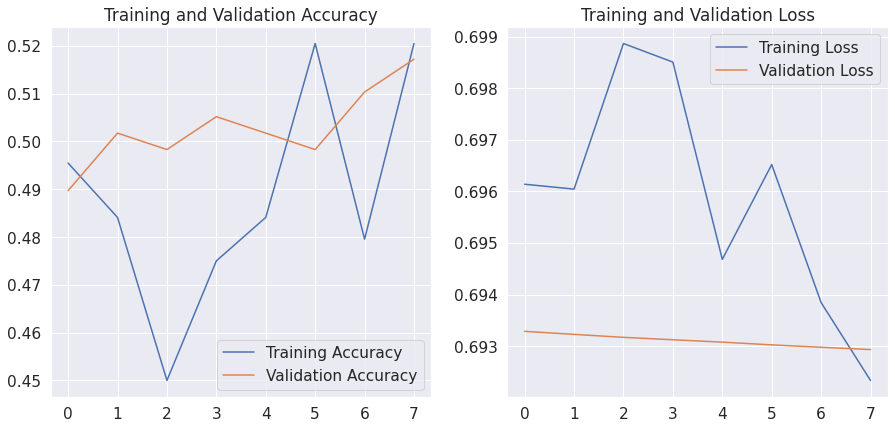

In [19]:
acc = history_pert.history['accuracy']
val_acc = history_pert.history['val_accuracy']
loss = history_pert.history['loss']
val_loss = history_pert.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Confusion Matrix

In [20]:
num_of_train_samples = 602
num_of_test_samples = 582

In [21]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [22]:
validation_generator = test_datagen.flow_from_directory("preprocessing/val_data",
                                                        target_size=(224, 224),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 587 images belonging to 2 classes.


Confusion Matrix
[[176 129]
 [145 137]]


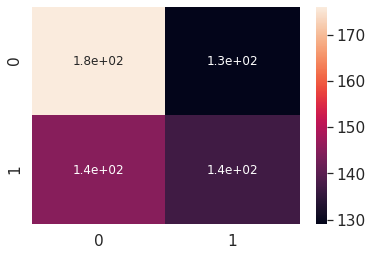

In [23]:
Y_pred = model_pert.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
confusion_matrix_array = confusion_matrix(validation_generator.classes, y_pred)
print(confusion_matrix_array)
df_cm = pd.DataFrame(confusion_matrix_array, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

### Classification Report

In [24]:
predictions = model_pert.predict_classes(x_val)
predictions = predictions.reshape(1,-1)[0]

target_names = ['Female (Class 0)','Male (Class 1)']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names, zero_division=1))

                  precision    recall  f1-score   support

Female (Class 0)       0.55      0.58      0.56       305
  Male (Class 1)       0.52      0.49      0.50       282

        accuracy                           0.53       587
       macro avg       0.53      0.53      0.53       587
    weighted avg       0.53      0.53      0.53       587



# Making predictions

## Without Pertubation

In [25]:
def predictImage(filename):
    img = tf.keras.preprocessing.image.load_img(filename, target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(img)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    input_arr = input_arr.astype('float32') / 255.  # This is VERY important
    predictions = model.predict(input_arr)
    val = np.argmax(predictions, axis=-1)
    
    img1 = image.load_img(filename,target_size=(img_size,img_size))
    plt.imshow(img1)
    if val == 1:
        plt.xlabel("MALE",fontsize=30)
    elif val == 0:
        plt.xlabel("FEMALE",fontsize=30)

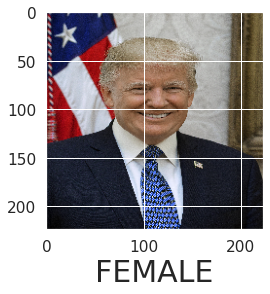

In [26]:
predictImage("trump.jpeg")

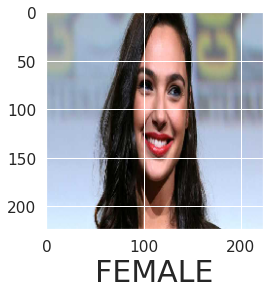

In [27]:
predictImage("gal.jpeg")

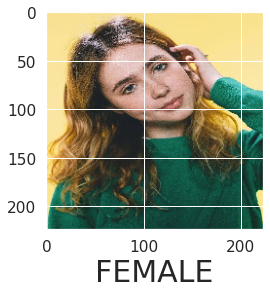

In [28]:
predictImage("clairo.jpeg")

## With Pertubation

In [29]:
def predictImagePert(filename):
    img = tf.keras.preprocessing.image.load_img(filename, target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(img)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    input_arr = input_arr.astype('float32') / 255.  # This is VERY important
    predictions = model_pert.predict(input_arr)
    val = np.argmax(predictions, axis=-1)
    
    img1 = image.load_img(filename,target_size=(img_size,img_size))
    plt.imshow(img1)
    if val == 1:
        plt.xlabel("MALE",fontsize=30)
    elif val == 0:
        plt.xlabel("FEMALE",fontsize=30)

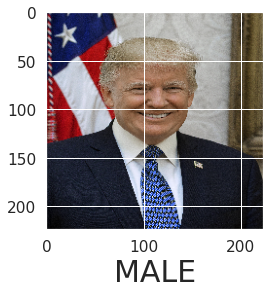

In [30]:
predictImagePert("trump.jpeg")

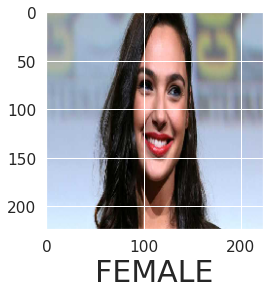

In [31]:
predictImagePert("gal.jpeg")

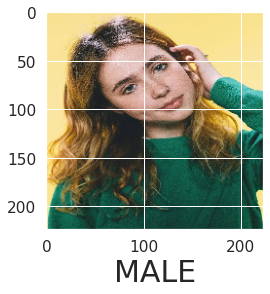

In [32]:
predictImagePert("clairo.jpeg")